# Exercise 4

This week we will practice how to conduct data classification and aggregation using geopandas. Last week in exercise 3 we analyzed buffer zones around shopping centers. This week we will take into account travel distances using data from the [Helsinki Region Travel Time Matrix](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/).


## Problem 1: Join accessibility datasets into a grid and visualize the data on a map (10 points)


![P1 example result](img/traveltimes_example.png)

*Desired output from problem 1: Travel times by public transport (PT) and car to Itis and Myyrmanni*

**Data:**

The [data/](data/) directory in this repository contains all the required input data for this exercise:
 
- Travel time data: `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` (Travel times and distances in the Helsinki Region to different shopping centers  as text files)
- Reference grid: `MetropAccess_YKR_grid_EurefFIN.shp`. 

Column `from_id` in the travel time data sets corresponds to the `YKR_ID` column in the grid shapefile.
     
**Steps:**

In problem 1 we will focus on travel times to **Itis** and **Myyrmanni**. Our goal is to visualize travel times by public transport and car to both shopping centers. Before plotting the maps we need to classify the data. Your task is to **first develop the processing steps using Itis as input**, and then repeat the steps for Myyrmanni.

- Read the Polygon grid `MetropAccess_YKR_grid_EurefFIN.shp` into a GeoDataFrame called `grid` using geopandas:

In [2]:
import pandas as pd
import geopandas as gpd

fp = "data/MetropAccess_YKR_grid_EurefFIN.shp"
grid = gpd.read_file(fp)
grid.head()

,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [3]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nYKR GRID:", len(grid), "rows")


YKR GRID: 13231 rows


- Read the travel time data file for Itis using Pandas into a variable called `data`. Separator is `";"` in the input file.
- Select only following columns from the file:
    
   - `pt_r_t`
   - `car_r_t`
   - `from_id`
   - `to_id`

In [8]:
fp = "data/TravelTimes_to_5944003_Itis.txt"
data = pd.read_csv(fp, sep=';')
data = data[['pt_r_t', 'car_r_t', 'from_id', 'to_id']]
data.head()

,pt_r_t,car_r_t,from_id,to_id
0,132,50,5785640,5944003
1,135,51,5785641,5944003
2,137,58,5785642,5944003
3,141,57,5785643,5944003
4,125,50,5787544,5944003


In [9]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nITIS:", len(data), "rows")


ITIS: 13231 rows


- join attributes from `data` to `grid` using the [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function: 
  - **`YKR_ID`** -column in `grid` corresponds to the **`from_id`** column in `data`
  - store the join output into a variable called `data_geo` 

In [21]:
data_geo = pd.merge(data, grid, left_on='from_id', right_on='YKR_ID' )
data_geo = gpd.GeoDataFrame(data_geo)

,pt_r_t,car_r_t,from_id,to_id,x,y,YKR_ID,geometry
0,132,50,5785640,5944003,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,135,51,5785641,5944003,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,137,58,5785642,5944003,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,141,57,5785643,5944003,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,125,50,5787544,5944003,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [20]:
# NON-EDITABLE TEST CELL
#Check data type
assert type(data_geo) == gpd.geodataframe.GeoDataFrame, "Output should be a geodataframe."

In [22]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['YKR_ID', 'pt_r_t', 'car_r_t', 'geometry']

assert all(x in data_geo.columns for x in required_columns), "Couldn't find all required columns."

- Remove all rows containing no-data values (`-1`) from `data_geo`. You can for example [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) the no-data values with numpy's `np.nan`, and then drop rows containing no-data values using the [DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function.

In [30]:
import numpy as np

data_geo = data_geo.replace(-1, np.nan)
data_geo = data_geo.dropna()

In [31]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
assert -1 not in data_geo["pt_r_t"], "NoData values (-1) should be removed from the data!"


- Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
    - Create a `UserDefined` classifier using the [pysal/mapclassify](https://github.com/pysal/mapclassify#userdefined) library using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
    - Apply the classifier to `pt_r_t` and `car_r_t` columns and store the results to `pt_r_t_cl` and `car_r_t_cl` columns, respectively
    - Notice that these 12 class breaks will produce 13 classes (1 class break divides the data into two classes).

In [43]:
import mapclassify
classifier = mapclassify.UserDefined.make(bins = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
data_geo['pt_r_t_cl'] = data_geo[['pt_r_t']].apply(classifier)
data_geo['car_r_t_cl'] = data_geo[['car_r_t']].apply(classifier)

0        12
1        12
2        12
3        12
4        12
         ..
13225    12
13226    12
13227    12
13229    12
13230    12
Name: pt_r_t_cl, Length: 13020, dtype: int32


In [44]:
# NON-EDITABLE TEST CELL
#Check the output
print("travel times by public transport:")
print(data_geo[['YKR_ID', 'pt_r_t', 'pt_r_t_cl']].head())

travel times by public transport:
    YKR_ID  pt_r_t  pt_r_t_cl
0  5785640   132.0         12
1  5785641   135.0         12
2  5785642   137.0         12
3  5785643   141.0         12
4  5787544   125.0         12


In [45]:
# NON-EDITABLE TEST CELL
#Check the output
print("Travel times by car:")
print(data_geo[['YKR_ID','car_r_t', 'car_r_t_cl']].head())

Travel times by car:
    YKR_ID  car_r_t  car_r_t_cl
0  5785640     50.0           9
1  5785641     51.0          10
2  5785642     58.0          11
3  5785643     57.0          11
4  5787544     50.0           9


**Plot the classified travel times to Itis**:

![itis_example.png](img/itis_example.png)

Create a 1x2 plot where the you plot travel times by public transport and travel times by car to Itis:
- Create subplots using matplotlib having 1 row and 2 columns (use parameters `nrows` & `ncols`), and the figure size should be 10 inches by 5 inches (use parameter `figsize`)
- Add titles for the subplots as seen in the example above
- Remove the empty whitespace around the plots using function `plt.tight_layout()`
- Save the figure into disk with filename `itis_accessibility.png`


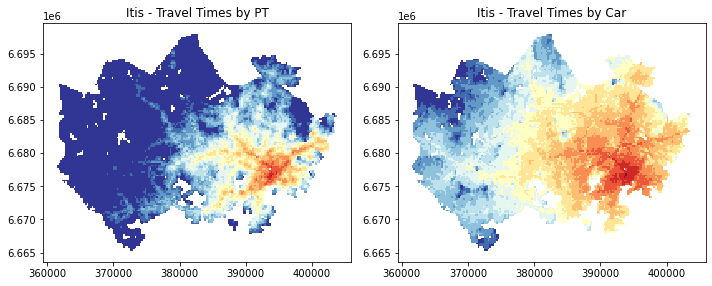

In [54]:
# Define output filename for the figure in here and use it when saving the file:
output_fig1 = "data/itis_accessibility.png"

import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

data_geo.plot(column='pt_r_t_cl', cmap="RdYlBu", ax=ax1)

# Add title
ax1.set_title("Itis - Travel Times by PT")

# Plot the one with ETRS-LAEA projection
data_geo.plot(column='car_r_t_cl', cmap="RdYlBu", ax=ax2)

# Add title
ax2.set_title("Itis - Travel Times by Car")

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

fig.savefig(output_fig1)

In [55]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig1), "figure does not exists!"

**Repeat the steps for Myyrmanni:**

![myyrmanni example figure](img/myyrmanni_example.png)

Next, your task is to repeat all the same steps for **Myyrmanni** (`data/TravelTimes_to_5902043_Myyrmanni.txt`):

    # Read text file using pandas into a variable called data
    # Select columns 'pt_r_t', 'car_r_t', 'from_id', 'to_id'
    # Make table join between grid and travel time data. Store output in a variable called data_geo
    # Remove no data values
    # Classify the values in columns 'pt_r_t', 'car_r_t' into new columns 'pt_r_t_cl', 'car_r_t_cl'
    # Plot travel times by public transport and travel times by car.
    # Save output image to file (myyrmanni_accessibility.png)

*Hint: You can copy paste the code from your earlier solutions in here, just change the input file path.*


In [ ]:
# Define output filename for the figure in here and use it when saving the file:
output_fig2 = ""

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

In [ ]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig2), "figure does not exists!"


**Optional:  4-panel figure**

As an optional task, plot travel times to Itis and Myyrmanni all in one 4-panel figure (see example at the top of this page)!

Hints:
- create a for-loop where you repeat all the steps for Itis and Myyrmanni (you can iterate over a list of input filepaths)
- Before the for-loop, create a figure with 4 subplots (2 rows and 2 columns) and use figsize=(10,10)
- Inside the for-loop, plot each map into one of the subplots. 
- save the figure as `shopping_center_accessibility.png` 

In [ ]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

**Finally**, check that you have provided adequate comments in your code.

**Reflections:** (Only for enrolled students)
- If you want to ask feedback on spesific parts of your code, please leave your comment in here: 

YOUR ANSWER HERE

### Done!


**Remember to commit the output figures** to your exercise repository! (One for Itis and one for Myyrmanni, or optionally a combined 4-panel figure for both shopping centers and both travel modes).

That's it! Once you have plotted the data and saved the output you are ready to continue with Problem 2.